In [1]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm

import random
import numpy as np
import pandas as pd

import datetime as dt
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import cv2

import keras

from keras.callbacks import TensorBoard

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from mpl_toolkits.axes_grid1 import ImageGrid

from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.models import Model


from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau


from keras import backend as K

# from keras.applications import vgg16, resnet50, mobilenet
# from keras.applications.vgg16 import VGG16
# from keras.applications.resnet50 import ResNet50
# from keras.applications import xception
# from keras.applications import inception_v3

from keras.applications.inception_v3 import InceptionV3

from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.optimizers import SGD




np.random.seed(2)
sns.set(style='white', context='notebook', palette='deep')

C:\Users\Andromeda\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
def show_pred(preds, Y, val_breed, index, seq, ran):
    leng = len(preds)
    if seq:
        for i in range(index):
            if ran:
                index = random.randint(0, leng) 
            _, imagenet_class_name, prob = decode_predictions(preds, top=1)[index][0]
            plt.title("Original: " + val_breed[Y[index]] + "\nPrediction: " + imagenet_class_name)
            plt.imshow(X_train[index])
            plt.show()
    else:
            _, imagenet_class_name, prob = decode_predictions(preds, top=1)[index][0]
            plt.title("Original: " + val_breed[Y[index]] + "\nPrediction: " + imagenet_class_name)
            plt.imshow(X_train[index])
            plt.show()
        
def accuracy_func(preds, Y, val_breed):
    leng = len(preds)
    count = 0;
    for i in range(leng):
        _, imagenet_class_name, prob = decode_predictions(preds, top=1)[i][0]
        if val_breed[Y[i]] == imagenet_class_name:
            count+=1
    accuracy = (count/leng)*100
    
    print("Accuracy: ", accuracy)
    return accuracy

In [10]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [11]:
# #Load the VGG model
# vgg_model = vgg16.VGG16(weights='imagenet')
 
# #Load the Inception_V3 model
# inception_model = inception_v3.InceptionV3(weights='imagenet')
 
# #Load the ResNet50 model
# resnet_model = resnet50.ResNet50(weights='imagenet')
 
# #Load the MobileNet model
# mobilenet_model = mobilenet.MobileNet(weights='imagenet')

In [15]:
training_path = 'data/training'
validation_path = 'data/validation'
testing_path = 'data/test'
batch_size = 32
target_size=(224, 224)
norm = 255.0
class_mode='categorical'

In [16]:
train_datagen = ImageDataGenerator(
        rescale=1./norm,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./norm)
test_datagen = ImageDataGenerator(rescale=1./norm)

train_generator = train_datagen.flow_from_directory(
        training_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# test_generator = test_datagen.flow_from_directory(
#         testing_path,
#         target_size=target_size,
#         batch_size=batch_size,
#         class_mode=class_mode)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [17]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [29]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(10, activation='softmax')(x)


In [30]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [31]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True



0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [32]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate



sgd = optimizers.Adam()
# sgd = optimizers.SGD()
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# sgd = optimizer=SGD(lr=0.0001, momentum=0.9)

model.compile(sgd, loss='categorical_crossentropy', metrics=["accuracy"])

# model.compile(loss='mean_squared_error', optimizer='sgd')

In [39]:
model_dir = 'outputs/models/'
log_file = "outputs/logs"

model_file = model_dir+"weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

In [40]:
checkpoint = keras.callbacks.ModelCheckpoint(model_file, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [41]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [42]:
tensorboard = keras.callbacks.TensorBoard(log_dir=log_file, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
tensorboard.set_model(model) 

In [43]:
callbacks_list = [early_stopping, checkpoint, tensorboard]
# callbacks_list = [checkpoint, tensorboard]

In [44]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/15
35/35 [==============================] - ETA: 8:06 - loss: 0.1062 - acc: 0.937 - ETA: 7:09 - loss: 0.2498 - acc: 0.906 - ETA: 6:28 - loss: 0.2187 - acc: 0.916 - ETA: 5:59 - loss: 0.2416 - acc: 0.906 - ETA: 5:40 - loss: 0.2513 - acc: 0.912 - ETA: 5:26 - loss: 0.2797 - acc: 0.906 - ETA: 5:17 - loss: 0.2467 - acc: 0.915 - ETA: 5:06 - loss: 0.2293 - acc: 0.918 - ETA: 4:53 - loss: 0.2160 - acc: 0.920 - ETA: 4:42 - loss: 0.2353 - acc: 0.918 - ETA: 4:30 - loss: 0.2355 - acc: 0.917 - ETA: 4:20 - loss: 0.2207 - acc: 0.921 - ETA: 4:09 - loss: 0.2117 - acc: 0.925 - ETA: 3:56 - loss: 0.2292 - acc: 0.921 - ETA: 3:47 - loss: 0.2346 - acc: 0.918 - ETA: 3:38 - loss: 0.2381 - acc: 0.916 - ETA: 3:29 - loss: 0.2359 - acc: 0.919 - ETA: 3:17 - loss: 0.2338 - acc: 0.920 - ETA: 3:05 - loss: 0.2372 - acc: 0.921 - ETA: 2:53 - loss: 0.2532 - acc: 0.920 - ETA: 2:41 - loss: 0.2422 - acc: 0.924 - ETA: 2:29 - loss: 0.2372 - acc: 0.927 - ETA: 2:17 - loss: 0.2302 - acc: 0.929 - ETA: 2:05 - loss: 0.2291 - a

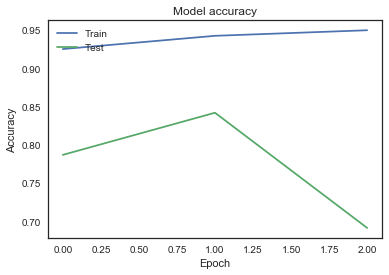

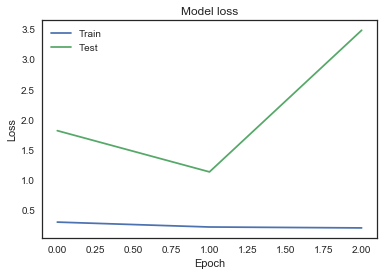

In [47]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [49]:
filepath = 'outputs/models/weights-improvement-02-0.84.hdf5'
model = keras.models.load_model(filepath)

In [50]:
# preds = model.predict_generator(test_generator, verbose=1)

NameError: name 'test_generator' is not defined

In [ ]:
# categorical_accuracy = keras.metrics.categorical_accuracy(test_generator.classes, preds)

In [ ]:
# result = model.evaluate_generator(generator=test_generator, verbose=1)

In [93]:
# print("%s%.2f%s"% ("Accuracy: ", result[1]*100, "%"))
# print("%s%.2f"% ("Loss: ", result[0]))

In [94]:
def get_class_values(gen):
    vals = []
    for i in gen:
        vals.append(gen[i])
    return vals

def get_classes(gen):
    rev_gen = {}
    for i in gen:
        rev_gen[gen[i]] = i
    return rev_gen

def find_max(preds_i):
    num = -1
    index = -1
    for i in range(len(preds_i)):
        if preds_i[i]>num:
            num = preds_i[i]
            index = i
    return index  

def get_label(cls, val):
    return cls[val]

In [95]:
vals = get_class_values(train_generator.class_indices)
cls = get_classes(train_generator.class_indices)

In [96]:
monkeys = {"n0" : ["alouatta_palliata", "mantled_howler"],
           "n1" : ["erythrocebus_patas", "patas_monkey"],
           "n2" : ["cacajao_calvus", "bald_uakari"], 
           "n3" : ["macaca_fuscata", "japanese_macaque"],
           "n4" : ["cebuella_pygmea", "pygmy_marmoset"],
           "n5" : ["cebus_capucinus", "white_headed_capuchin"] ,
           "n6" : ["mico_argentatus", "silvery_marmoset"],
           "n7" : ["saimiri_sciureus", "common_squirrel_monkey"]  ,
           "n8" : ["aotus_nigriceps", "black_headed_night_monkey"],
           "n9" : ["trachypithecus_johnii", "nilgiri_langur"]}


In [97]:
import re
latin_name = {}
original_name = {}

for sp in monkeys:
    latin_name[sp] = re.sub(r'_', ' ', monkeys[sp][0]).title()
    original_name[sp] = re.sub(r'_', ' ', monkeys[sp][1]).title()
    
print(latin_name)
print(original_name)

{'n0': 'Alouatta Palliata', 'n1': 'Erythrocebus Patas', 'n2': 'Cacajao Calvus', 'n3': 'Macaca Fuscata', 'n4': 'Cebuella Pygmea', 'n5': 'Cebus Capucinus', 'n6': 'Mico Argentatus', 'n7': 'Saimiri Sciureus', 'n8': 'Aotus Nigriceps', 'n9': 'Trachypithecus Johnii'}
{'n0': 'Mantled Howler', 'n1': 'Patas Monkey', 'n2': 'Bald Uakari', 'n3': 'Japanese Macaque', 'n4': 'Pygmy Marmoset', 'n5': 'White Headed Capuchin', 'n6': 'Silvery Marmoset', 'n7': 'Common Squirrel Monkey', 'n8': 'Black Headed Night Monkey', 'n9': 'Nilgiri Langur'}


In [98]:
f="data\\validation\\n0\\n000.jpg"

In [99]:
img1 = cv2.imread(f, 3)
img1 = cv2.resize(img1, (255,255))
img1 = np.array(img1).reshape((1, 255, 255, 3))#do not miss the order in tuple
img1 = img1/norm
p = model.predict(img1)
pp=find_max(p.flatten())
pp = cls[pp]
lat = latin_name[pp]
org = original_name[pp]
print(pp)
print(lat)
print(org)

n0
Alouatta Palliata
Mantled Howler


In [100]:
# total = 0
# acc = 0
# direc = "data\\test"
# files = test_generator.filenames
# for i in range(len(preds)):
#     cls_index = find_max(preds[i])
#     pred_label = cls[cls_index]
#     org_label = cls[test_generator.classes[i]]
#     file_name = os.path.join(direc, files[i])
#     if org_label==pred_label:
#         acc +=1
#     if total%10==0:
#         result = "Wrong!!!\n"
#         if org_label==pred_label:
#             result = "Right!!!\n"
#         title_text = "Original: "+ org_label+"\nPredicted: "+ pred_label+"\nFile: "+ file_name
#         title_text=result+ title_text
        
#         img = cv2.imread(file_name, 3)
#         if org_label==pred_label:
#             plt.title(title_text, color='blue')
#         else:
#             plt.title(title_text, color='red')
#         plt.imshow(img)
#         plt.show()
    
#     total+=1
# accuracy = (acc/total)*100
# print("Accuracy: ", accuracy)

NameError: name 'test_generator' is not defined